# Competition goal

* Identify fractures in CT scans of the cervical spine (neck) at both the level of a single vertebrae and the entire patient. 
* It's a **multi label classification task** with labels C1-C7 (seven cervical vertebrae).
* There are supplemental files with another segmentation in the sagittal plane.

# Prepare to start <a class="anchor" id="prepare"></a>

## Loading packages

In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image
import cv2
from skimage.segmentation import mark_boundaries

import tensorflow as tf

from tqdm.notebook import tqdm
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn

import seaborn as sns
sns.set()

from lime import lime_image

import shap

## Loading data

In [2]:
train = pd.read_csv("../input/rsna-2022-cervical-spine-fracture-detection/train.csv")

# Exploratory analysis <a class="anchor" id="eda"></a>

## What do we know about our training data?

In [3]:
train.head()

,StudyInstanceUID,patient_overall,C1,C2,C3,C4,C5,C6,C7
0,1.2.826.0.1.3680043.6200,1,1,1,0,0,0,0,0
1,1.2.826.0.1.3680043.27262,1,0,1,0,0,0,0,0
2,1.2.826.0.1.3680043.21561,1,0,1,0,0,0,0,0
3,1.2.826.0.1.3680043.12351,0,0,0,0,0,0,0,0
4,1.2.826.0.1.3680043.1363,1,0,0,0,0,1,0,0


In [4]:
train.shape

(2019, 9)

* The **StudyInstanceUID** The study ID.
* The **patient_overall** The patient level outcome, i.e. if any of the vertebrae are fractured.
* **C1-C7** Whether the given vertebrae is fractured.

2019 Studies in train.

1058 146 285 73 108 162 277 393


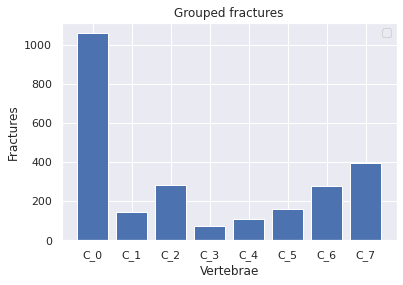

In [5]:
C_0 = train[train.patient_overall == 0]["StudyInstanceUID"].count()
C_1 = train[train.C1 == 1]["StudyInstanceUID"].count()   
C_2 = train[train.C2 == 1]["StudyInstanceUID"].count()   
C_3 = train[train.C3 == 1]["StudyInstanceUID"].count()   
C_4 = train[train.C4 == 1]["StudyInstanceUID"].count()   
C_5 = train[train.C5 == 1]["StudyInstanceUID"].count()   
C_6 = train[train.C6 == 1]["StudyInstanceUID"].count()   
C_7 = train[train.C7 == 1]["StudyInstanceUID"].count()   

labels = ["C_0", "C_1", "C_2", "C_3", "C_4", "C_5", "C_6", "C_7"]
values = [C_0, C_1, C_2, C_3, C_4, C_5, C_6, C_7]

print(C_0, C_1, C_2, C_3, C_4, C_5, C_6, C_7)

plt.bar(labels, values)
  
plt.xlabel("Vertebrae")
plt.ylabel("Fractures")
plt.title("Grouped fractures")
plt.legend()
plt.show()

**Imbalanced classification problem**

# Images

In [6]:
!conda install '../input/gdcm-notebook/libgcc-ng-9.3.0-h2828fa1_19.tar.bz2' -c conda-forge -y
!conda install '../input/gdcm-notebook/gdcm-2.8.9-py37h500ead1_1.tar.bz2' -c conda-forge -y
!conda install '../input/gdcm-notebook/conda-4.10.1-py37h89c1867_0.tar.bz2' -c conda-forge -y
!conda install '../input/gdcm-notebook/certifi-2020.12.5-py37h89c1867_1.tar.bz2' -c conda-forge -y
!conda install '../input/gdcm-notebook/openssl-1.1.1k-h7f98852_0.tar.bz2' -c conda-forge -y


######################################################################## | 100% 
Preparing transaction: - done
Verifying transaction: | done
Executing transaction: - \ done

######################################################################## | 100% 
Preparing transaction: - done
Verifying transaction: | done
Executing transaction: - done

######################################################################## | 100% 
Preparing transaction: - done
Verifying transaction: | done
Executing transaction: - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / done

######################################################################## | 100% 
Preparing transaction: - done
Verifying transaction: | done
Executing transaction: - done

######################################################################## | 100% 
Preparing transaction: - done
Verifying transaction: | done
Executing transaction: - \ | / - \ 

In [7]:
import pydicom as dicom
from pydicom import dcmread
import matplotlib.pylab as plt
import cv2 

#bad_images 

# studies = os.listdir("../input/rsna-2022-cervical-spine-fracture-detection/train_images")

# for study in studies:
#     path_study = "../input/rsna-2022-cervical-spine-fracture-detection/train_images/" + study + "/"
#     images = os.listdir(path_study)
#     for image in images:
#         ds = dcmread(path_study + image)
#         try: 
#             trying = ds.pixel_array
#         except:
#             print(path_study)
#             break

In [8]:
f = open("../input/badimages/bad_images.txt", "r")
bad_images = []

# reading the file
data = f.read()
  
# replacing end of line('/n') with ' ' and
# splitting the text it further when '.' is seen.
bad_images = data.replace('\n', ' ').split(",")
  
# printing the data
print(bad_images[1])
f.close()

 ../input/rsna-2022-cervical-spine-fracture-detection/train_images/1.2.826.0.1.3680043.2668/


## Presenting Images

../input/rsna-2022-cervical-spine-fracture-detection/train_images/1.2.826.0.1.3680043.17625/
../input/rsna-2022-cervical-spine-fracture-detection/train_images/1.2.826.0.1.3680043.17625/95.dcm


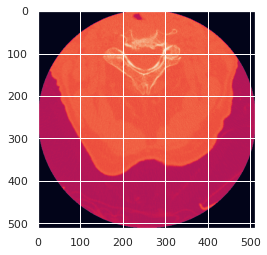

In [9]:
train_path = "../input/rsna-2022-cervical-spine-fracture-detection/train_images/"
studies = os.listdir(train_path)


path_study = train_path + studies[0] + "/"
print(path_study)

images = os.listdir(path_study)
path_image = path_study + images[8]
print(path_image)

ds = dicom.dcmread(path_image)
plt.imshow(ds.pixel_array)

In [10]:
# View above Study labels:

train[train["StudyInstanceUID"] == "1.2.826.0.1.3680043.17625"]

,StudyInstanceUID,patient_overall,C1,C2,C3,C4,C5,C6,C7
1645,1.2.826.0.1.3680043.17625,1,0,1,0,0,0,0,0
